In [1]:
import napari
import matplotlib.pyplot as plt
from napari_video.napari_video import VideoReaderNP
import glob
import pandas as pd
import numpy as np
import warnings
import pickle
# from tqdm import tqdm
# import os
warnings.filterwarnings("ignore")

In [45]:
def removeROI(df, roi, start, stop):
    if type(start) == int or type(start) == float:
        df2 = df.copy()
        scorer = df.columns.get_level_values(0)[0]
        x_min = roi[:,1].min()
        x_max = roi[:,1].max()
        y_min = roi[:,0].min()
        y_max = roi[:,0].max()
        for ind in df2.columns.get_level_values(1).unique():
            for bp in df2.columns.get_level_values(2).unique():
                df2[scorer, ind, bp, 'x'].iloc[start:stop].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                                   (df2[scorer, ind, bp, 'x'] < x_max) & 
                                                   (df2[scorer, ind, bp, 'y'] > y_min) & 
                                                   (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan

                df2[scorer, ind, bp, 'y'].iloc[start:stop].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                                   (df2[scorer, ind, bp, 'x'] < x_max) & 
                                                   (df2[scorer, ind, bp, 'y'] > y_min) & 
                                                   (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan
        return df2
    
    elif start == 'all':
        df2 = df.copy()
        scorer = df.columns.get_level_values(0)[0]
        x_min = roi[:,1].min()
        x_max = roi[:,1].max()
        y_min = roi[:,0].min()
        y_max = roi[:,0].max()
        for ind in df2.columns.get_level_values(1).unique():
            for bp in df2.columns.get_level_values(2).unique():
                df2[scorer, ind, bp, 'x'].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                                   (df2[scorer, ind, bp, 'x'] < x_max) & 
                                                   (df2[scorer, ind, bp, 'y'] > y_min) & 
                                                   (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan

                df2[scorer, ind, bp, 'y'].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                                   (df2[scorer, ind, bp, 'x'] < x_max) & 
                                                   (df2[scorer, ind, bp, 'y'] > y_min) & 
                                                   (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan
        return df2
    else:
        print('Wrong start stop input')



In [46]:
# video_path = '/mnt/DATA/biteData/P3/210715_mp4/210715_KPPTN_denv5_6DLC_resnet50_aedesNov16shuffle1_80000_bx_id_labeled.mp4'
video_path = '/Users/felix/Documents/mosquitoes/mosquitoData/P3/cleaning/201105_KPPTN_denv3_4DLC_resnet50_aedesNov16shuffle1_80000_bx_id_labeled.mp4'
hdf = video_path[:-17] + 'bx.h5'
# hdf = video_path[:-8] + 'bx.h5'
df = pd.read_hdf(hdf)
scorer = df.columns.get_level_values(0)[0]

In [47]:
vr = VideoReaderNP(video_path)

In [48]:
### This opens the video in the napari viewer. Use a rectangular shape to mark the ROI that needs to be excluded for all time points. 
viewer = napari.Viewer()
image_layer = viewer.add_image(vr, rgb=True)

In [77]:
###PROVIDE THE NUMER OF ROIS THAT IS REQUIRED

numROIsreq = 2

In [51]:
for i in range(0,numROIsreq):
    roiName = 'ROI' + str(i)
    viewer.add_shapes(shape_type='rectangle', name=roiName)


In [66]:
rois = []

for i in range(0,numROIsreq):
    roiName = 'ROI' + str(i)
    roi = viewer.layers[roiName].data
    print('provide start for ROI ' + str(i))
    start = input()
    print('provide stop for ROI ' + str(i))
    stop = input()
    rois.append([roi, int(start), int(stop)])

provide start for ROI 0


 0


provide stop for ROI 0


 12860


provide start for ROI 1


 11900


provide stop for ROI 1


 31998


In [67]:
cleaningPkl = hdf[:-5] + 'cleaningPkl.pkl'
with open(cleaningPkl, 'wb') as f:
    pickle.dump(rois, f)

In [74]:
df2 = df.copy()

for ROI in rois:
    df2 = removeROI(df2, ROI[0][0], ROI[1], ROI[2])

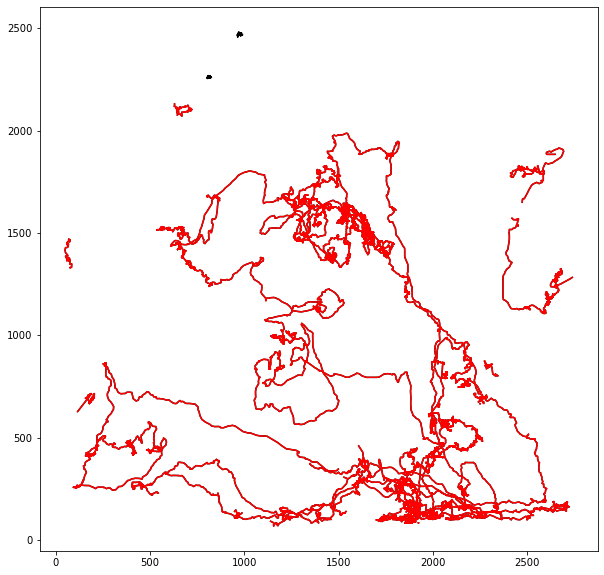

In [75]:
plt.figure(figsize=(10,10))

for ind in df.columns.get_level_values(1).unique():
    plt.plot(df[scorer, ind, 'head'].x, df[scorer, ind, 'head'].y, 'k')
    
for ind in df2.columns.get_level_values(1).unique():
    plt.plot(df2[scorer, ind, 'head'].x, df2[scorer, ind, 'head'].y, 'r')

In [76]:
newHdf = hdf[:-5] + 'clean.h5'
df2.to_hdf(newHdf, key="df_with_missing", mode="w")